### Read input data

In [1]:
DATE = "2024-01-25"

import pandas as pd
import os

ANNOTATED_NODES_CSV = f"data/reachable-nodes-annotated-{DATE}.csv"
assert os.path.exists(ANNOTATED_NODES_CSV), "Annotated node data missing! Run `reproduce_input_data.ipynb` to create."
df = pd.read_csv(ANNOTATED_NODES_CSV)

# address statistics
num_ipv4 = sum(df.network == 'ipv4')
num_ipv6 = sum(df.network == 'ipv6')
num_ip = len(df)
assert num_ipv4 + num_ipv6 == num_ip, "Inconsistent dichotomy"
print(f'reachable nodes: ipv4={num_ipv4}, ipv6={num_ipv6}, ipv4/ipv6={num_ip}')

# netgroup statistics
ng_all = df.netgroup.value_counts().values
ng_ipv4 = df[df.network == 'ipv4'].netgroup.value_counts().values
ng_ipv6 = df[df.network == 'ipv6'].netgroup.value_counts().values
assert sum(ng_ipv4) + sum(ng_ipv6) + sum(ng_all) == 2 * len(df), "Inconsistent dichotomy!"
print(f'netgroups: ipv4={len(ng_ipv4)}, ipv6={len(ng_ipv6)}, ipv4/ipv6={len(ng_all)}, total_addresses={sum(ng_all)}')

# AS statistics
as_all = df.asn.value_counts().values
as_ipv4 = df[df.network == 'ipv4'].asn.value_counts().values
as_ipv6 = df[df.network == 'ipv6'].asn.value_counts().values
assert sum(as_ipv4) + sum(as_ipv6) + sum(as_all) == 2 * len(df), "Inconsistent dichotomy!"
print(f'as: ipv4={len(as_ipv4)}, ipv6={len(as_ipv6)}, ipv4/ipv6={len(as_all)}, total_addresses={sum(as_all)}')

reachable nodes: ipv4=6298, ipv6=1935, ipv4/ipv6=8233
netgroups: ipv4=3591, ipv6=418, ipv4/ipv6=4009, total_addresses=8233
as: ipv4=1062, ipv6=448, ipv4/ipv6=1191, total_addresses=8233


### Monte Carlo simulation to quantify netgroup-to-as mapping

In [2]:
import numpy as np

from tqdm import tqdm

ng_to_as = pd.Series(df.asn.values,index=df.netgroup).to_dict()

def count_unique_as(ng_list):
    """Determine number of unique autonomous systems from a list of netgroups."""
    global ng_to_as
    unique_as = {ng_to_as[ng] for ng in ng_list}
    return len(unique_as)

def monte_carlo(ng_to_size, num_draws: int = 10, iterations: int = 10000):
    """Perform Monte Carlo simulation with 10,000 iterations, in each instance
    drawing ten distinct netgroups and determining to how many unique autonomous
    systems these netgroups corresond."""

    population = list(ng_to_size.keys())
    ng_size = np.array(list(ng_to_size.values()))
    p = ng_size/ng_size.sum()
    result = []
    for _ in tqdm(range(iterations)):
        draw = np.random.choice(population, num_draws, replace=False, p=p)
        num_unique_as = count_unique_as(draw)
        result.append(num_unique_as)
    return result

params = {
    'IPv4': df[df.network == 'ipv4'].netgroup.value_counts().to_dict(),
    'IPv6': df[df.network == 'ipv6'].netgroup.value_counts().to_dict(),
    'IPv4/IPv6': df.netgroup.value_counts().to_dict(),
}

results = {}
for label, data in params.items():
    results[label] = monte_carlo(data)

100%|██████████| 10000/10000 [00:04<00:00, 2292.16it/s]


### Plot

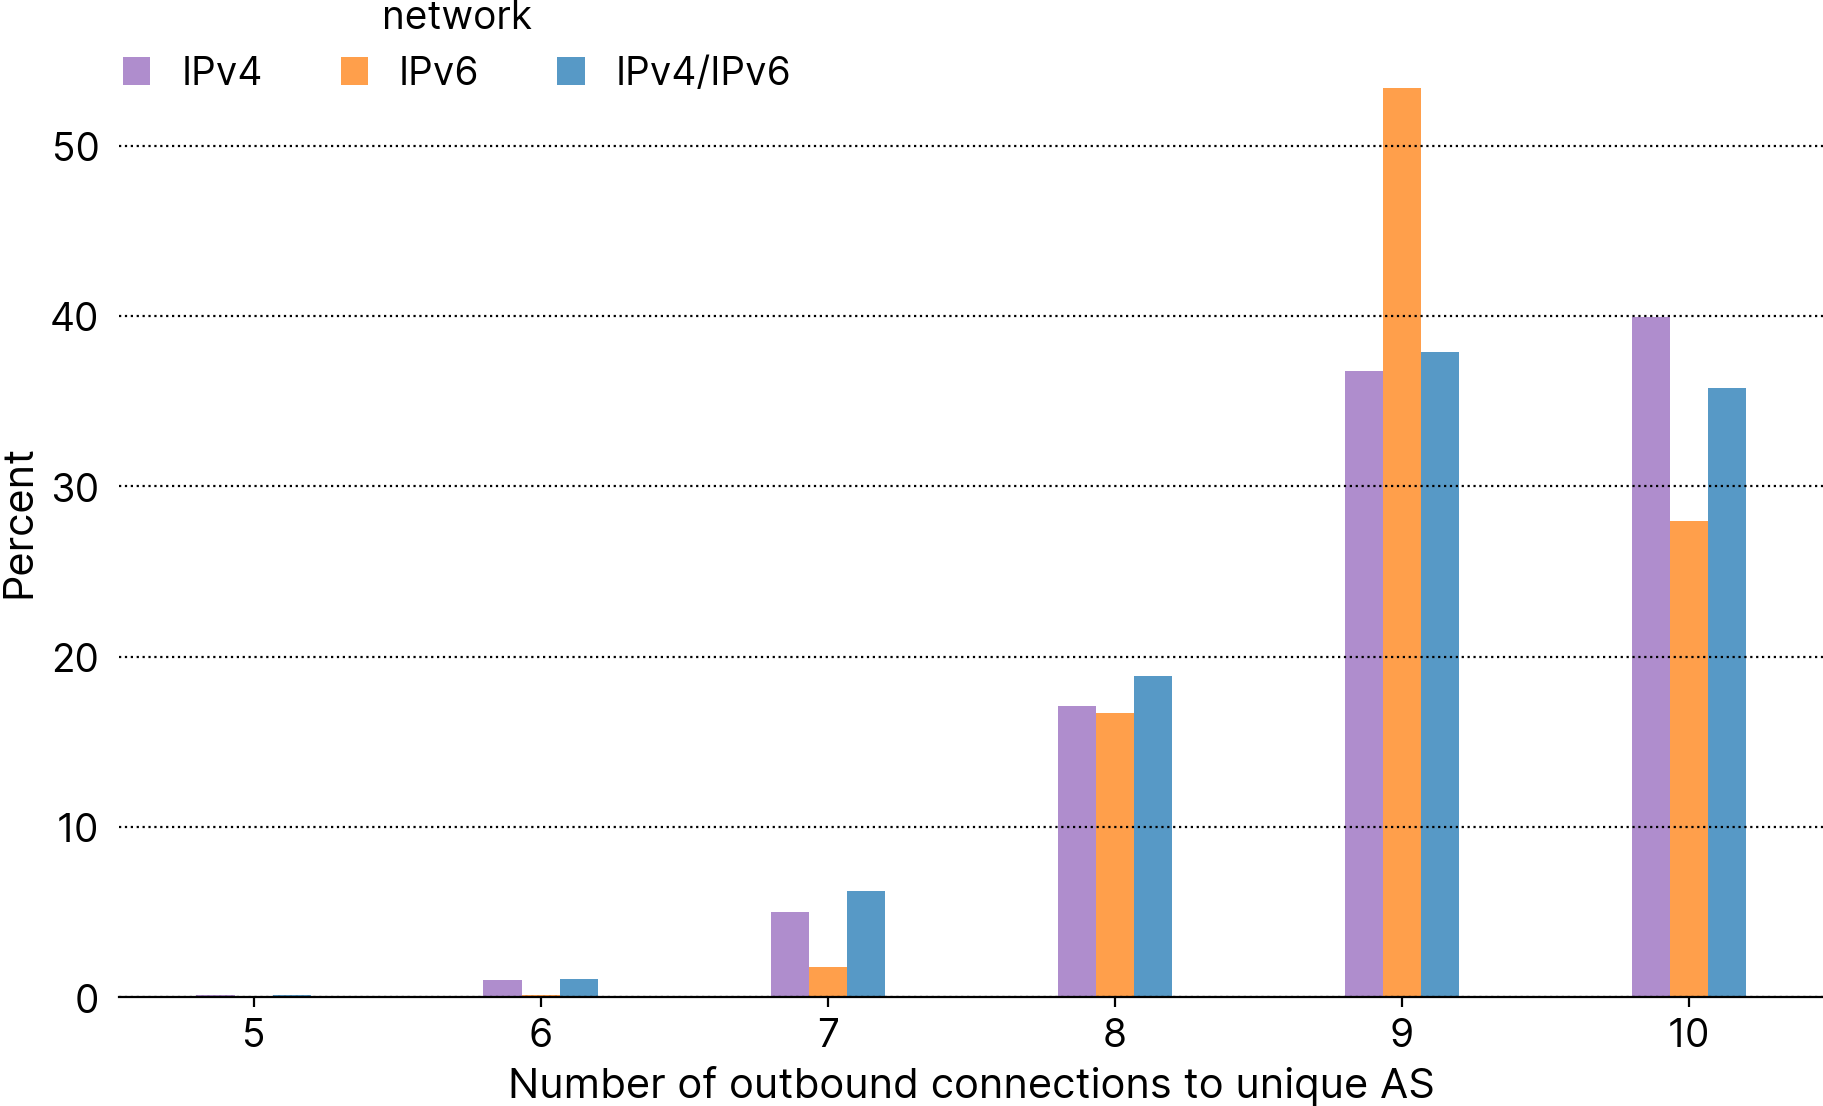

In [3]:
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib import patches

data = pd.DataFrame(results)
data_melted = data.melt(var_name='network', value_name='Number of outbound connections to unique AS')

_ = sns.histplot(data=data_melted, x='Number of outbound connections to unique AS', hue='network', discrete=True, shrink=0.4, multiple='dodge', stat='percent', common_norm=False, legend=True, edgecolor=None)